In [1]:
from csv import DictReader

with open('data/combustdb_master.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    rows = [r for r in reader]
csv_file.close()

compounds = [r for r in rows if r['properties.cetane_number.value'] != '-']
print(len(compounds))

408


In [2]:
from alvadescpy import smiles_to_descriptors

descriptors = [smiles_to_descriptors(c['canonical_smiles']) for c in compounds]

In [3]:
import pandas as pd
import numpy as np

df = pd.DataFrame(descriptors)

X = df.values
for i in range(len(X)):
    for j in range(len(X[i])):
        if X[i][j] == 'na':
            X[i][j] = 0.0
X = X.astype('float32')

y = np.array([[float(c['properties.cetane_number.value'])] for c in compounds], dtype='float32')

print(X.shape, y.shape)

(408, 5305) (408, 1)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)

X_norm = scaler.transform(X)
print(X_norm.shape)

(408, 5305)


In [5]:
from sklearn.decomposition import PCA

pca = PCA(svd_solver='full', random_state=0)
pca.fit(X_norm)
X_pca = pca.transform(X_norm)
print(X_pca.shape)

(408, 408)


In [6]:
N_PC_TO_EVAL = 408

X_pca_eval = np.array([[x[i] for i in range(N_PC_TO_EVAL)] for x in X_pca])
print(X_pca_eval.shape)

(408, 408)


In [7]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=30, metric='euclidean', algorithm='brute')
clf.fit(X_pca_eval)
neg_outlier_factors = clf.negative_outlier_factor_
print(len(neg_outlier_factors))

408


In [8]:
with open('pca_results.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    results = [r for r in reader]
csv_file.close()

In [9]:
pred = [float(r['pred']) for r in results]
actual = [float(r['actual']) for r in results]

err = [pred[i] - actual[i] for i in range(len(pred))]

327


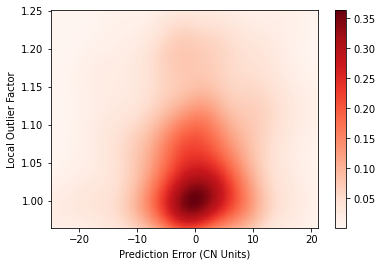

In [10]:
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

err_to_plot = []
of_to_plot = []
for i in range(len(err)):
    if abs(err[i]) < 25 and neg_outlier_factors[i] > -1.25:
        err_to_plot.append(err[i])
        of_to_plot.append(neg_outlier_factors[i])

print(len(err_to_plot))

nbins=500
x = np.array(err_to_plot)
y = np.array([o * -1 for o in of_to_plot])

k = gaussian_kde([x, y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

plt.clf()
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=plt.cm.Reds)
plt.colorbar()
plt.xlabel('Prediction Error (CN Units)')
plt.ylabel('Local Outlier Factor')
plt.show()